<a href="https://colab.research.google.com/github/victor-roris/ML-learning/blob/master/ComputerVision/DeepLearning_ComputerVision_ImageMultiLabelClassification_DataSpartan_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Label CNN Image Classification 

In this notebook we generate a multi-label model to try to tag images of tables (from a **non public dataset**) with different labels. Each table can be tagged as: lined, padding, zebra or non-zebra.


[BLOG](https://medium.com/@gsurma/image-tagger-multi-label-cnn-image-classification-5b0a87f0084d)

[GITHUB](https://github.com/gsurma/image_tagger/blob/master/ImageTagger.ipynb)

## Install

In [4]:
!pip install livelossplot

clear_output()

## Import

In [5]:
import os
import pandas as pd
import string
import random
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from keras import backend as K
from ast import literal_eval
from sklearn.utils import class_weight
from keras.models import Sequential
from keras.models import load_model
from keras.metrics import top_k_categorical_accuracy
from keras.callbacks import ModelCheckpoint
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from livelossplot import PlotLossesKeras
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

## Dataset

### Download data

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [8]:
dataset_folderpath = "/content/input"

In [9]:
import os
if os.path.isdir(dataset_folderpath):
  !rm -R {dataset_folderpath}

In [10]:
from pathlib import Path
def mkdir(sfolderpath):
  folderpath = Path(sfolderpath)
  folderpath.mkdir(parents=True, exist_ok=True)

mkdir(dataset_folderpath)

In [11]:
!tar -xvf /content/drive/My\ Drive/DATASPARTAN/PROYECTOS/AI-DOCUMENTS/SEGMENTATION/DSTableDataset.tar.gz -C {dataset_folderpath}

clear_output()

!ls {dataset_folderpath}

dataset_folderpath = os.path.join(dataset_folderpath, "raw")

raw  setup.py


### Generate dataframe

Get labels

In [16]:
import pandas as pd


folders = [name for name in os.listdir(dataset_folderpath) 
      if os.path.isdir(os.path.join(dataset_folderpath,name))]
print(f"Folders : {folders}")

indv_cls = []
for cls in folders:
    icls = cls.split("_")
    for icl in icls:
        if icl not in indv_cls:
            indv_cls.append(icl)
print(f"Labels : {indv_cls}")

Folders : ['lined_nozebra', 'padding_zebra', 'lined_zebra', 'padding_nozebra']
Labels : ['lined', 'nozebra', 'padding', 'zebra']


Generate dataframes

In [17]:
ALL_IMAGES = list(Path(dataset_folderpath).glob("**/*.*"))
ALL_IMAGES = list(filter(lambda x: not x.name.startswith("."), ALL_IMAGES))

IMAGE_PATH_KEY = "filepath"
TAGS_PATH_KEY = "labels"

data_llist = {IMAGE_PATH_KEY:[], TAGS_PATH_KEY:[]}
data_labels = { icls : [] for icls in indv_cls }
data_labels[IMAGE_PATH_KEY]=[]


for imagepath in ALL_IMAGES:
  img_labels = imagepath.parents[0].name
  img_labels = img_labels.split("_")

  data_llist[IMAGE_PATH_KEY].append(str(imagepath))
  data_llist[TAGS_PATH_KEY].append(img_labels)

  data_labels[IMAGE_PATH_KEY].append(str(imagepath))
  for icls in indv_cls:
    if icls in img_labels:
      data_labels[icls].append(1)
    else:
      data_labels[icls].append(0)


df_llist = pd.DataFrame (data_llist, columns = list(data_llist.keys()))
df_labels = pd.DataFrame (data_labels, columns = list(data_labels.keys()))

In [18]:
print(len(df_llist))
df_llist.head()

474


,filepath,labels
0,/content/input/raw/lined_nozebra/129-Table4.2-...,"[lined, nozebra]"
1,/content/input/raw/lined_nozebra/dl_data5.png,"[lined, nozebra]"
2,/content/input/raw/lined_nozebra/s9asu.png,"[lined, nozebra]"
3,/content/input/raw/lined_nozebra/Study-sample-...,"[lined, nozebra]"
4,/content/input/raw/lined_nozebra/Captura de pa...,"[lined, nozebra]"


In [19]:
print(len(df_labels))
df_labels.head()

474


,lined,nozebra,padding,zebra,filepath
0,1,1,0,0,/content/input/raw/lined_nozebra/129-Table4.2-...
1,1,1,0,0,/content/input/raw/lined_nozebra/dl_data5.png
2,1,1,0,0,/content/input/raw/lined_nozebra/s9asu.png
3,1,1,0,0,/content/input/raw/lined_nozebra/Study-sample-...
4,1,1,0,0,/content/input/raw/lined_nozebra/Captura de pa...


Get the list of all the labels

In [20]:
all_labels = [] 

for tags in df_llist[TAGS_PATH_KEY].values.tolist():
    for tag in tags:
        all_labels.append(tag)

### Split `train`, `val` and dataset

Randomize the dataframe

In [21]:
df_llist = df_llist.sample(frac=1)
df_labels = df_labels.sample(frac=1)

Split datasets

In [22]:
from sklearn.model_selection import train_test_split

train_size = 0.85
test_size = 1 - train_size

df_llist_train, df_llist_test = train_test_split(df_llist, train_size=train_size, test_size=test_size)
df_llist_val, df_llist_test   = train_test_split(df_llist_test, train_size=train_size, test_size=test_size)

df_labels_train, df_labels_test = train_test_split(df_labels, train_size=train_size, test_size=test_size)
df_labels_val, df_labels_test = train_test_split(df_labels_test, train_size=train_size, test_size=test_size)

print(f"Number of train examples : {len(df_llist_train)}")
print(f"Number of validation examples : {len(df_llist_val)}")
print(f"Number of test examples : {len(df_llist_test)}")

Number of train examples : 402
Number of validation examples : 61
Number of test examples : 11


### Generate Image Loaders

In [23]:
IMAGE_SIZE = 224
BATCH_SIZE = 16
RANDOM_SEED = 115


from keras_preprocessing.image import ImageDataGenerator

from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

training_data_generator = ImageDataGenerator(rotation_range=30,
                                             zoom_range=0.2,
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             shear_range=0.2,
                                             horizontal_flip=True,
                                             fill_mode="nearest",
                                             preprocessing_function=preprocess_input)

training_generator = training_data_generator.flow_from_dataframe(dataframe=df_llist_train,
                                                                 x_col=IMAGE_PATH_KEY, 
                                                                 y_col=TAGS_PATH_KEY,
                                                                 batch_size=BATCH_SIZE,
                                                                 seed=RANDOM_SEED,
                                                                 class_mode="categorical",
                                                                 target_size=(IMAGE_SIZE, IMAGE_SIZE))

validation_generator = training_data_generator.flow_from_dataframe(dataframe=df_llist_val,
                                                                   x_col=IMAGE_PATH_KEY,
                                                                   y_col=TAGS_PATH_KEY,
                                                                   batch_size=BATCH_SIZE,
                                                                   seed=RANDOM_SEED,
                                                                   class_mode="categorical",
                                                                   target_size=(IMAGE_SIZE, IMAGE_SIZE))

testing_generator = training_data_generator.flow_from_dataframe(dataframe=df_llist_test,
                                                                   x_col=IMAGE_PATH_KEY,
                                                                   y_col=TAGS_PATH_KEY,
                                                                   batch_size=BATCH_SIZE,
                                                                   seed=RANDOM_SEED,
                                                                   class_mode="categorical",
                                                                   target_size=(IMAGE_SIZE, IMAGE_SIZE))

Found 402 validated image filenames belonging to 4 classes.
Found 61 validated image filenames belonging to 4 classes.
Found 11 validated image filenames belonging to 4 classes.


### Visualize some images

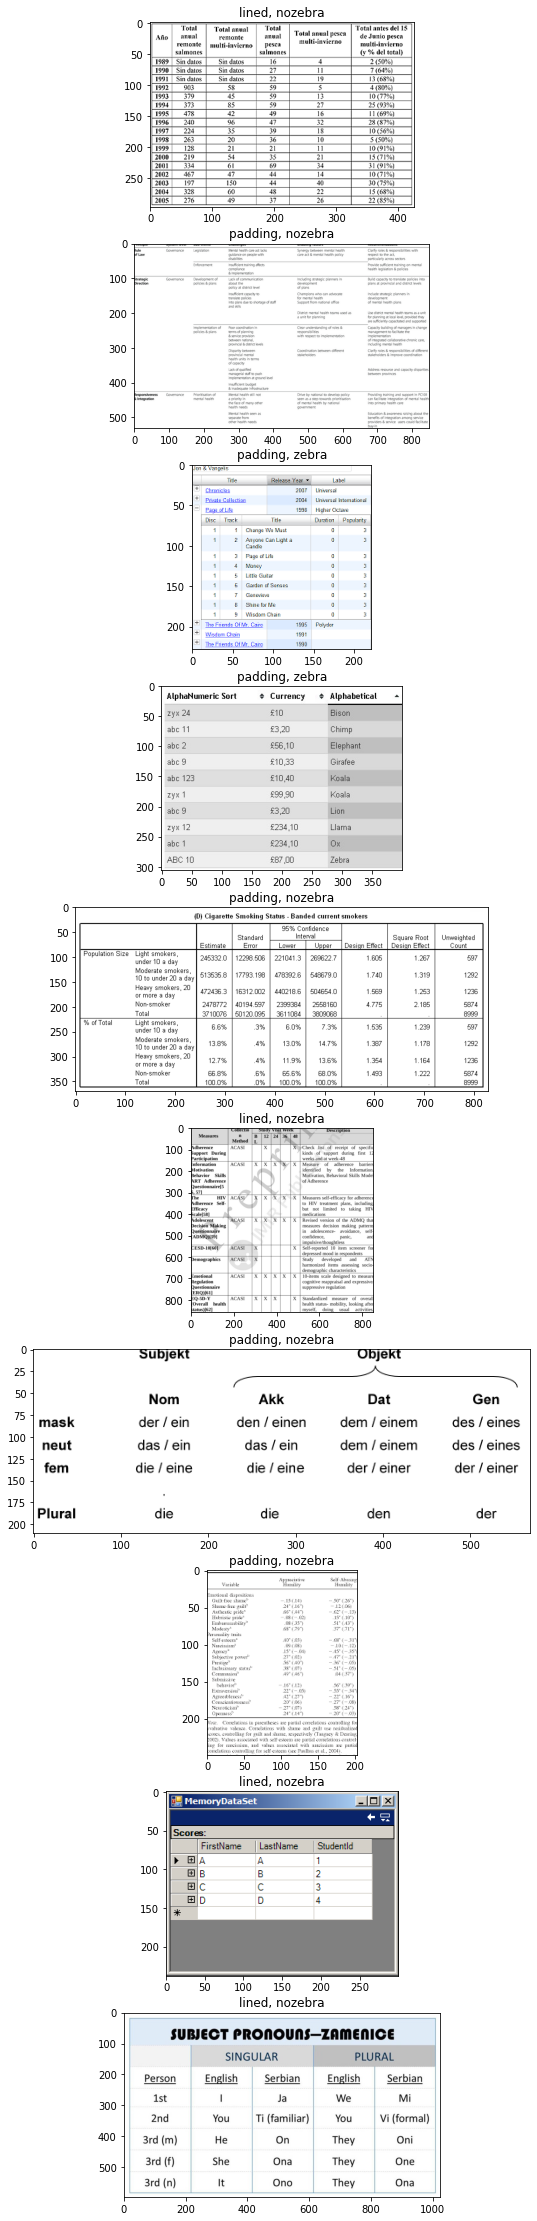

In [35]:
def show_images(images, titles, rows):
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        subplot = fig.add_subplot(rows, np.ceil(len(images)/float(rows)), n + 1)
        plt.imshow(image)
        subplot.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * len(images))
    plt.savefig("results.png", bbox_inches="tight", pad_inches=0)
    plt.show()
    plt.close()
    
images = []
titles = []

for idx in range(10):
    title = ""
    labels = training_generator.classes[idx]
    for label in labels:
        if title != "":
            title += ", "
        title += indv_cls[label]
            
    image_path = training_generator.filenames[idx]
    img = mpimg.imread(image_path)
    images.append(img)
    titles.append(title)
show_images(images, titles, len(images))

## TRAIN

### Define the model

In [43]:
EPOCHS = 20
DROPOUT = 0.5
FULLY_CONNECTED = 1024
LEARNING_RATE = 0.01
LEARNING_RATE_DECAY = LEARNING_RATE/100.0
CONFIDENCE_THRESHOLD = 0.9

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2*((p*r)/(p++K.epsilon()))

def get_model():
    def model(backbone):
        model = Sequential()
        model.add(backbone)
        model.add(GlobalAveragePooling2D())
        model.add(Dropout(DROPOUT))
        model.add(BatchNormalization())
        model.add(Dense(FULLY_CONNECTED, activation='relu'))
        model.add(Dense(len(indv_cls), activation='sigmoid'))
        model.compile(loss='binary_crossentropy',
                      optimizer=optimizers.Adam(lr=LEARNING_RATE, decay=LEARNING_RATE_DECAY),
                      metrics=["accuracy", recall, precision, f1])
        return model

    backbone = MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')
    backbone.trainable = False
    return model(backbone)

model = get_model()

### Training

In [44]:
# Setting class weights to handle imbalanced data
class_weights = class_weight.compute_class_weight('balanced',
                                                  indv_cls,
                                                  all_labels)

## https://stackoverflow.com/questions/61261907/on-colab-class-weight-is-causing-a-valueerror-the-truth-value-of-an-array-wit
# The problem is that the sklearn API returns a numpy array but the keras 
# requires a dictionary as an input for class_weight (see here). You can 
# resolve the error using below method:
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

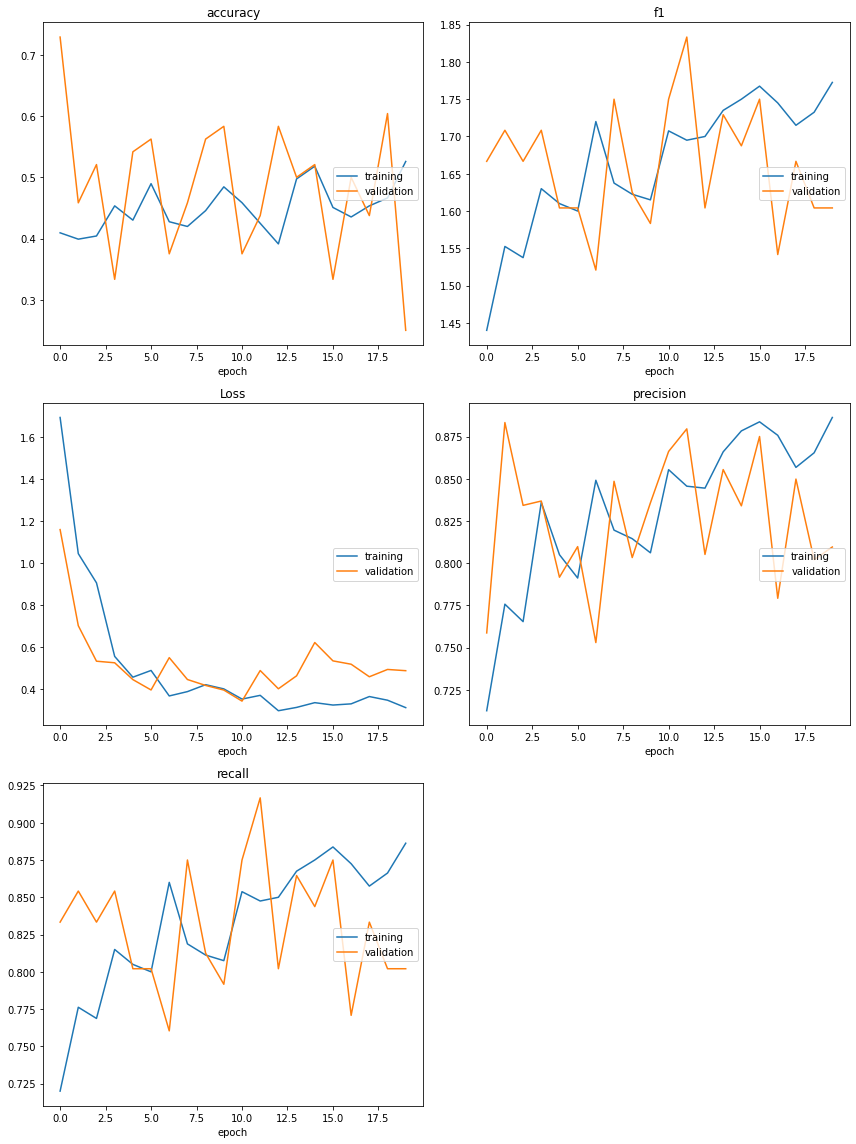

accuracy
	training         	 (min:    0.391, max:    0.526, cur:    0.526)
	validation       	 (min:    0.250, max:    0.729, cur:    0.250)
f1
	training         	 (min:    1.440, max:    1.772, cur:    1.772)
	validation       	 (min:    1.521, max:    1.833, cur:    1.604)
Loss
	training         	 (min:    0.296, max:    1.695, cur:    0.311)
	validation       	 (min:    0.342, max:    1.160, cur:    0.487)
precision
	training         	 (min:    0.713, max:    0.886, cur:    0.886)
	validation       	 (min:    0.753, max:    0.883, cur:    0.810)
recall
	training         	 (min:    0.720, max:    0.886, cur:    0.886)
	validation       	 (min:    0.760, max:    0.917, cur:    0.802)

Epoch 00020: val_f1 did not improve from 1.83333
25/25 [==============================] - 22s 861ms/step - loss: 0.3106 - accuracy: 0.5259 - recall: 0.8863 - precision: 0.8863 - f1: 1.7725 - val_loss: 0.4868 - val_accuracy: 0.2500 - val_recall: 0.8021 - val_precision: 0.8096 - val_f1: 1.6042


In [45]:
MODEL_PATH = "table_tagger.h5"

# Training
model.fit_generator(generator=training_generator,
                    class_weight=class_weights,
                    steps_per_epoch=training_generator.n // training_generator.batch_size,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.n // validation_generator.batch_size,
                    callbacks=[PlotLossesKeras(), 
                               ModelCheckpoint(MODEL_PATH,
                                               monitor='val_f1',
                                               mode='max',
                                               save_best_only=True,
                                               verbose=1)],
                    epochs=EPOCHS)
model = load_model(MODEL_PATH, custom_objects={"f1": f1,
                                               "recall": recall,
                                               "precision": precision})

## Test

In [46]:
# Testing
predictions = model.predict_generator(testing_generator,
                                      steps=len(df_llist_test),
                                      verbose=1)

 1/11 [=>............................] - 0s 11ms/step


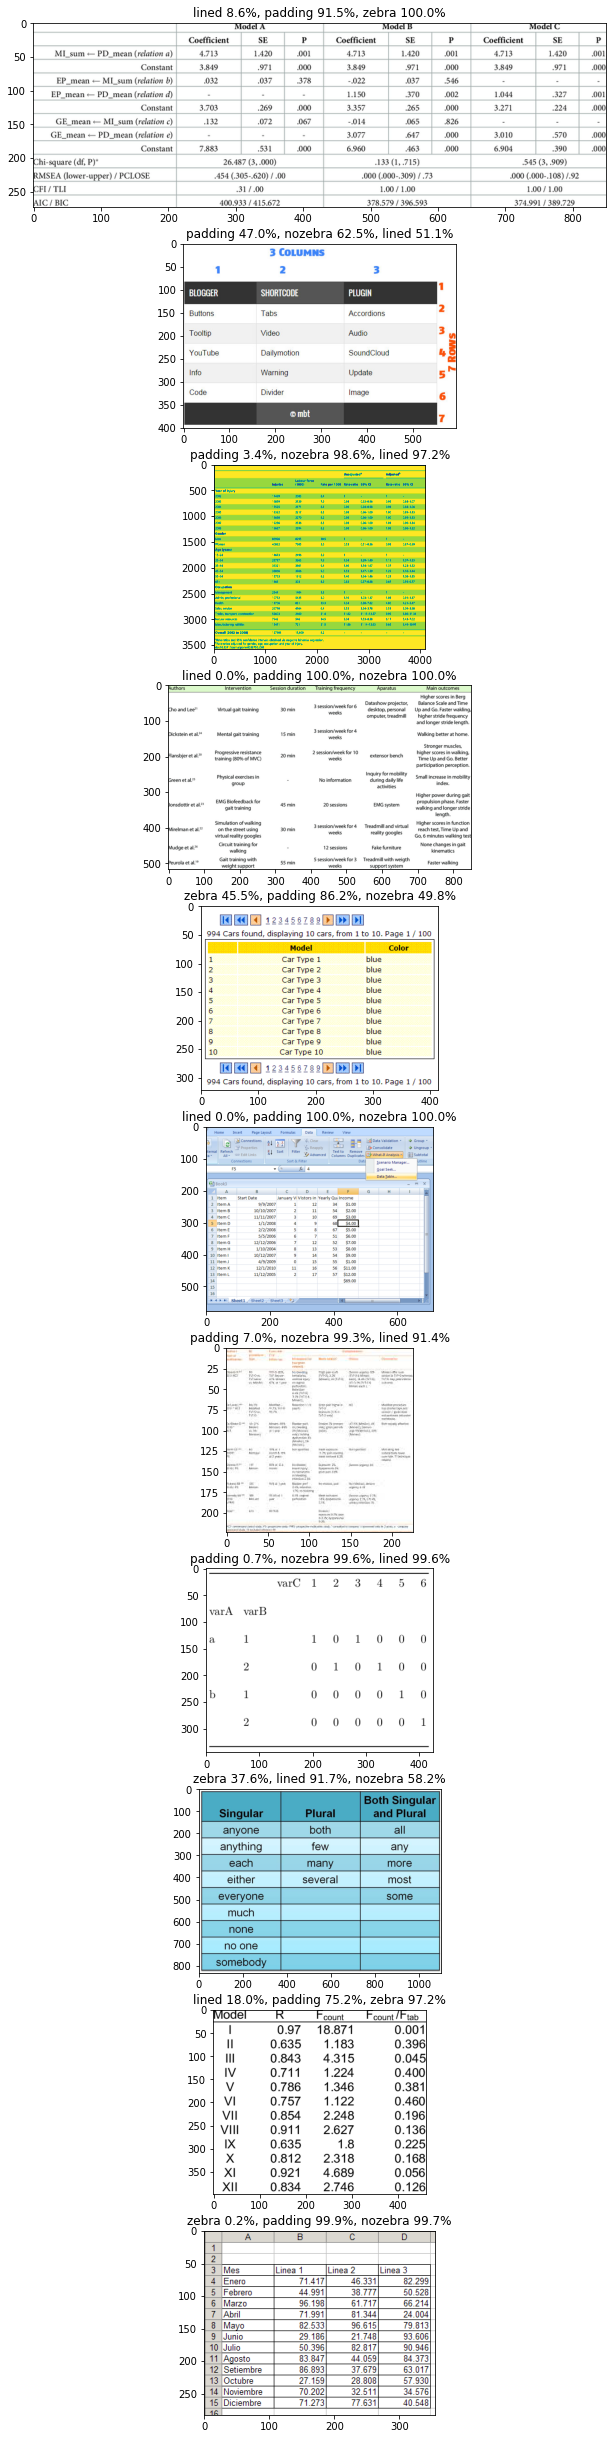

In [47]:
def show_images(images, titles, rows):
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        subplot = fig.add_subplot(rows, np.ceil(len(images)/float(rows)), n + 1)
        plt.imshow(image)
        subplot.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * len(images))
    plt.savefig("results.png", bbox_inches="tight", pad_inches=0)
    plt.show()
    plt.close()
    
images = []
titles = []

top_n = 3

for prediction_index, prediction in enumerate(predictions):
    title = ""
    top_n_indices = np.argpartition(prediction, -top_n)[-top_n:]
    for top_n_index in top_n_indices:
        if title != "":
            title += ", "
        title += (indv_cls[top_n_index] + " %.1f" % (prediction[top_n_index]*100) + "%")
            
    image_path = testing_generator.filenames[prediction_index]
    img = mpimg.imread(image_path)
    images.append(img)
    titles.append(title)
show_images(images, titles, len(images))